In [30]:
import os 
import pandas as pd
import polars as pl
import numpy as np
from tqdm import tqdm
import math 

from itertools import combinations
import matplotlib.pyplot as plt

from sortedcontainers import SortedList
from datetime import datetime

# Import package
import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from src.exchange import TOB_Exchange
from data_loader.tardis_loader import get_data

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# symbols = ['ETHUSDT', 'BTCUSDT', 'SOLUSDT', 'ADAUSDT', 'XRPUSDT']
symbols = ['ADAUSDT', 'XRPUSDT']
folder_path = 'data_loader/datasets/'

In [19]:
trades_list = []
quotes_list = []

for symbol in symbols: 
    # define folder path
    quotes_list += [
        f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
        and f.split('_')[0] == 'binance-futures' 
        and f.split('_')[-1] == symbol + '.csv.gz'
        and f.split('_')[1] == 'quotes']
    
    trades_list += [
        f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
        and f.split('_')[0] == 'binance-futures' 
        and f.split('_')[-1] == symbol + '.csv.gz'
        and f.split('_')[1] == 'trades']

In [20]:
def filter_list(file_list):
    tmp_list = SortedList(key=lambda x: x["timestamp"])
    for delta in file_list:
        date = datetime.strptime(delta[-len(symbol[1])-24:-len(symbol[1])-14], '%Y-%m-%d')
        if date > datetime(2023, 8, 31):
            tmp_list.add({'timestamp': date, 'file':delta})
    return tmp_list

In [21]:
trades_list = filter_list(trades_list)
quotes_list = filter_list(quotes_list)

trades_list = [i['file'] for i in trades_list]
quotes_list = [i['file'] for i in quotes_list]

In [25]:
quotes = get_data(quotes_list, folder_path=folder_path, data_type='quote')
trades = get_data(trades_list, folder_path=folder_path, data_type='trade')

In [33]:
binance = TOB_Exchange(exchange_type = 'future', fees=[0, 0])

usd_amount = 10_000
# prices = quotes.group_by(by='symbol').agg(pl.col("ask_price").max())

# per_asset = usd_amount // prices

In [34]:
for symbol in symbols: 
    binance.add_market(symbol, symbol[:-4], symbol[-4:])
    # binance.add_balance(symbol[:-4], per_asset[symbol])
    binance.add_balance(symbol[-4:], usd_amount)
    binance.load_tob(quotes.loc[quotes.symbol == symbol, ['timestamp', 'bid_amount', 'bid_price', 'ask_price', 'ask_amount']].sort_values('timestamp').to_numpy(), symbol)
    binance.load_trades(trades.loc[trades.symbol == symbol, ['timestamp', 'id', 'side', 'price', 'amount']].to_numpy(), symbol)

AttributeError: 'DataFrame' object has no attribute 'loc'

In [10]:
class Player: 
    def __init__(self, initial_rating: int = 1_000, K: int = 40):
        self.rating = initial_rating
        self.K = K
        self.min_rating = 0

    def win_probability(self, R_b):
        return 1.0 / (1.0 + math.exp(-((self.rating - R_b) / 400)))

    def update_rating(self, result, expected):
        new_rating = self.rating + self.K * (result - expected)
        self.rating = max(new_rating, self.min_rating)

In [11]:
class strategy:
    def __init__(self, exchange: TOB_Exchange, symbols: list, trading_interval: int) -> None:

        self.trading_interval = trading_interval * 60 * 1_000_000

        self.exchange: TOB_Exchange = exchange
        self.symbols = symbols
        self.base_position = 1_000

        self.players = self._initiate_players()
        self.close = {}
        self.last_close = {}
        self.stages = {i: 0 for i in symbols}
        self.last_timestamp = 0

        self.indicators = []

        self.elos = []

    def _initiate_players(self):
        players = {}

        for symbol in self.symbols: 
            players[symbol] = Player()
        return players
    

    def adjust_position(self, symbol: str, current: float, target: float, ts, price, gear: int): 
        
        if self.stages[symbol] != gear: 
            self.stages[symbol] = gear
            side = 1 if current < target else 0
            # print(symbol, side, current, target, abs(current-target))
            # price = update['High_'+symbol] if side == 'buy' else update['Low_'+symbol]
            self.exchange.market_order(symbol, abs(current-target) / price, side, ts)

    def _simulate_game(self, symbol1, symbol2, change):
        player_1: Player = self.players[symbol1]
        player_2: Player = self.players[symbol2]

        win_1 = player_1.win_probability(player_2.rating)
        actual = 1.0 if change[symbol1] > change[symbol2] else 0.0 
        player_1.update_rating(actual, win_1)
        player_2.update_rating(1-actual, 1-win_1)

    def decision(self, ts):
        
        changes = {symbol: np.log(self.close[symbol]) - np.log(self.last_close[symbol]) for symbol in self.symbols}
        # change = update.current_candle[self.close_symbols].astype('float64').apply(np.log) - update.last_candle[self.close_symbols].astype('float64').apply(np.log)

        # Update ELO Rankings
        for s in combinations(self.symbols, 2):
            self._simulate_game(s[0], s[1], changes)

        # Current ELO Rankings Sorted from bottom to top
        celo = sorted({p: self.players[p].rating for p in self.players.keys()}.items(), key=lambda x:x[1])

        self.elos.append([ts] + [self.players[p].rating for p in self.players.keys()])

        # Position for the bottom ranked is 2 * base, so betting on reversion
        n = -1
        positions = self.exchange.positions
        for symbol, rank in celo: 
            price = self.close[symbol]
            self.adjust_position(symbol=symbol, current=positions[symbol] * price, target=n * self.base_position, ts=ts, price=price, gear=n)
            n += 2
            
    def run_simulation(self):

        while len(self.exchange.live_events) > 0:
            self.exchange._simulation_step()

            ts = self.exchange.last_timestamp

            out = [ts]

            if ts > self.last_timestamp + self.trading_interval:

                self.last_timestamp = ts
                
                self.last_close = self.close 

                mids = {}

                for symbol in self.symbols: 
                    value = self.exchange.fetch_tob(symbol)
                    mids[symbol] = ((value['ask_price'] + value['bid_price']) / 2)

                self.close = mids
                out += mids.values()
                out += self.exchange.balances.values()
                out += self.exchange.positions.values()

                self.indicators.append(out)
                

                if len(self.last_close) > 0: 
                    self.decision(ts)
                else: 
                    pass

In [12]:
strat = strategy(binance, symbols, 15)
# strat.exchange.prepare_backtest()

In [13]:
type(strat.exchange.events)

sortedcontainers.sorteddict.SortedDict

In [14]:
from sortedcontainers import SortedDict

In [16]:
strat.exchange.events[1693526403998000.0]

deque([TOB(symbol='XRPUSDT', timestamp=1693526403998000.0, bq=144552.8, bp=0.5106, ap=0.5107, aq=47630.8)])

In [15]:
strat.exchange.events.keys()[:10]

[1693526403977000,
 1693526403979000,
 1693526403998000.0,
 1693526403999000.0,
 1693526404020000,
 1693526404035000,
 1693526404046000,
 1693526404051000.0,
 1693526404052000.0,
 1693526404053000]

In [39]:
strat.exchange.events.values()[:20][0]

deque([Trade(symbol='XRPUSDT', trade_id=372612, order_id=-1, side=1, taker=True, amount=245.6, price=0.5107, fees=0, entryTime=1693526403977000, eventTime=1693526403977000)])

In [27]:
strat.run_simulation()

2023-10-14 16:02:03,762 - INFO - src.exchange -  - Trade Executed Trade(symbol='XRPUSDT', trade_id=1274195, order_id=21, side=0, taker=True, amount=80.46227969654358, price=0.5112, fees=0.0, entryTime=1693527304013000.0, eventTime=1693527304016204.0)
2023-10-14 16:02:03,762 - INFO - src.exchange -  - Trade Executed Trade(symbol='ADAUSDT', trade_id=1274196, order_id=20, side=1, taker=True, amount=30.842482852253774, price=0.2557, fees=0.0, entryTime=1693527304013000.0, eventTime=1693527304019635.0)
2023-10-14 16:02:03,830 - INFO - src.exchange -  - Trade Executed Trade(symbol='XRPUSDT', trade_id=1274197, order_id=22, side=0, taker=True, amount=3916.966786378932, price=0.5099, fees=0.0, entryTime=1693528204244000.0, eventTime=1693528204247631.0)
2023-10-14 16:02:03,831 - INFO - src.exchange -  - Trade Executed Trade(symbol='ADAUSDT', trade_id=1274198, order_id=23, side=1, taker=True, amount=7815.56040969693, price=0.2562, fees=0.0, entryTime=1693528204244000.0, eventTime=1693528204248468

In [28]:
ind = pd.DataFrame(strat.indicators)
columns = ['ts'] + ['price_' + i for i in symbols] + ['balance_usd'] + ['balance_' + i for i in symbols]
ind.columns = columns
ind['time'] = pd.to_datetime(ind.ts, unit='us')
ind.set_index('time', inplace=True)

In [29]:
for symbol in symbols:
    ind['usd_' + symbol] = ind['balance_' + symbol] * ind['price_' + symbol]

In [30]:
usd_columns = ['usd_' + i for i in symbols]
ind['total_balance'] = ind.balance_usd + ind[usd_columns].sum(axis=1)

In [31]:
elo = pd.DataFrame(strat.elos)
elo_columns = ['elo_' + i for i in symbols]
elo.columns = ['ts'] + elo_columns
elo['ts'] = pd.to_datetime(elo.ts, unit='us')
elo.set_index('ts', inplace=True)

In [32]:
balances = pd.DataFrame(binance.historical_balance)

In [33]:
strat_trades = pd.DataFrame(strat.exchange.trades)

strat_trades.index = pd.to_datetime(strat_trades.eventTime, unit='us')
trades_a = strat_trades[strat_trades.symbol == 'SOLUSDT']
trades_b = strat_trades[strat_trades.symbol == 'BTCUSDT']

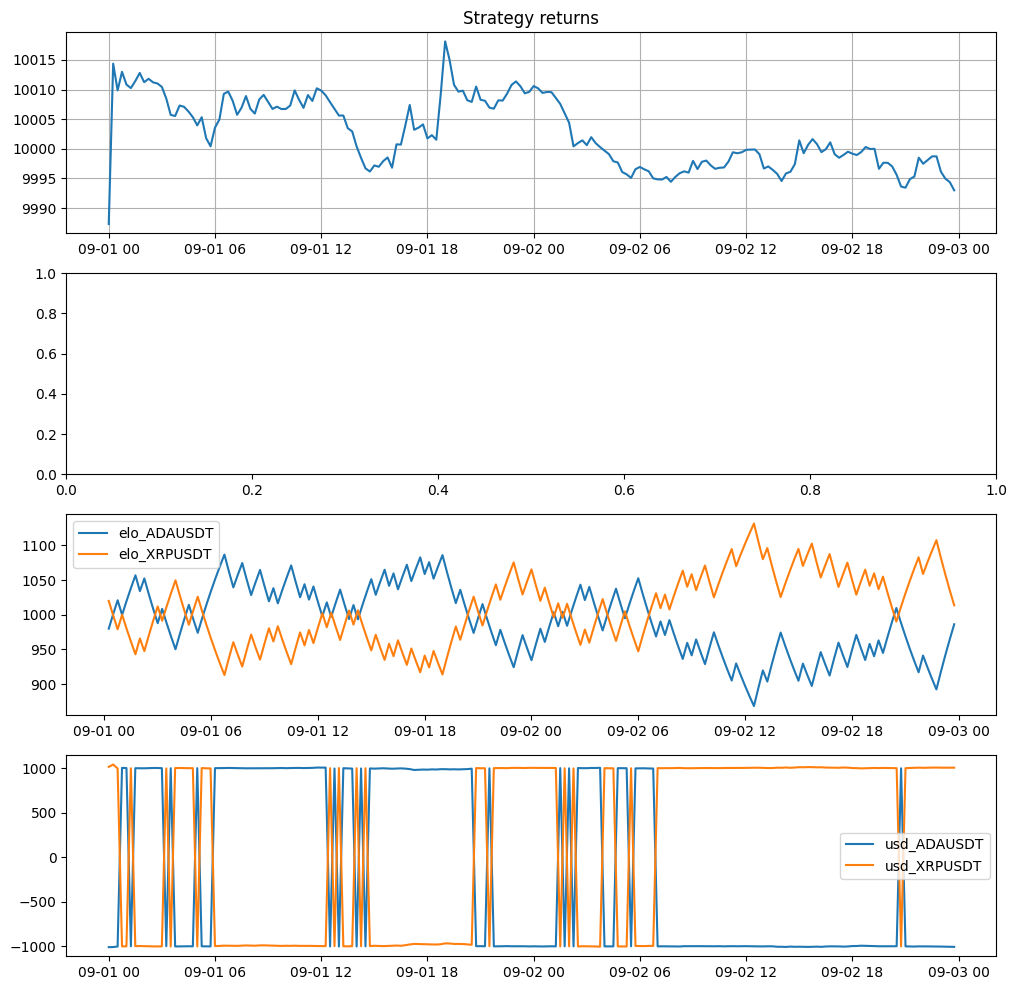

In [34]:
fig, axs = plt.subplots(4, figsize=(12, 12), facecolor='white')

ax1 = axs[0]
ax1.plot(ind.total_balance, label='Quote Balance')

ax2 = axs[1]
# ax22 = ax2.twinx()
# ax2.plot(ind.price_SOLUSDT, label='Price A', color='blue', alpha=0.5)
# ax2.scatter(trades_a[trades_a.side == 1].index, trades_a[trades_a.side == 1].price, color='green')
# ax2.scatter(trades_a[trades_a.side == 0].index, trades_a[trades_a.side == 0].price, color='red')


# ax22.plot(ind.price_BTCUSDT, label='Price B', color='orange', alpha=0.5)
# ax22.scatter(trades_b[trades_b.side == 1].index, trades_b[trades_b.side == 1].price, color='green')
# ax22.scatter(trades_b[trades_b.side == 0].index, trades_b[trades_b.side == 0].price, color='red')
# ax2.legend(loc=1)
# ax22.legend(loc=2)

ax3 = axs[2]
ax3.plot(elo, label=elo.columns)
ax3.legend()

ax4 = axs[3]
ax4.plot(ind[usd_columns], label=usd_columns)
ax4.legend()

ax1.set_title(f"Strategy returns")
ax1.grid()